In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## 데이터 불러오기

In [3]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

train.shape, test.shape

((7613, 5), (3263, 4))

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


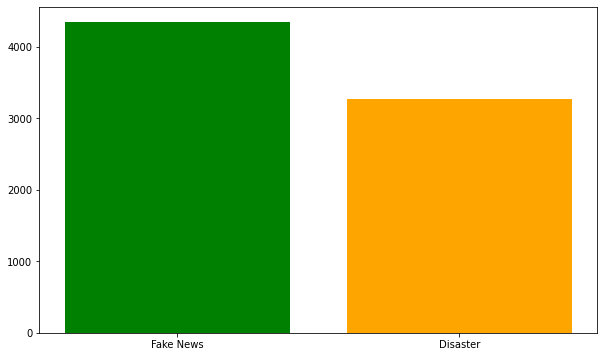

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

print(train['target'].value_counts())
news_class = train['target'].value_counts()
labels = ['Fake News', 'Disaster']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, news_class, color=['green', 'orange'])

fig.show()

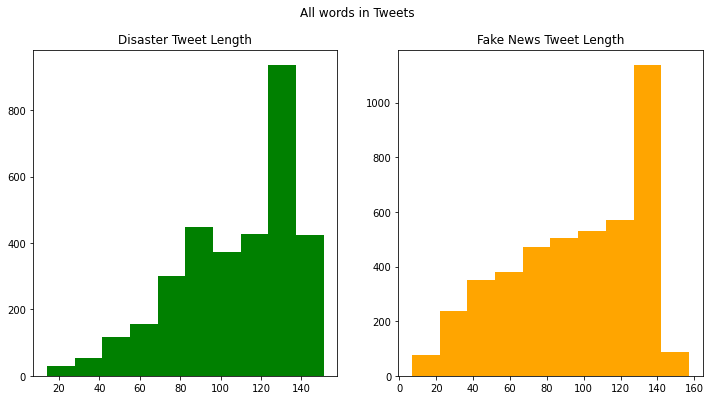

In [10]:
disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(disaster_tweet_len, color='green')
ax[0].set_title("Disaster Tweet Length")

ax[1].hist(non_disaster_tweet_len, color='orange')
ax[1].set_title("Fake News Tweet Length")

fig.suptitle('All words in Tweets')
plt.show()

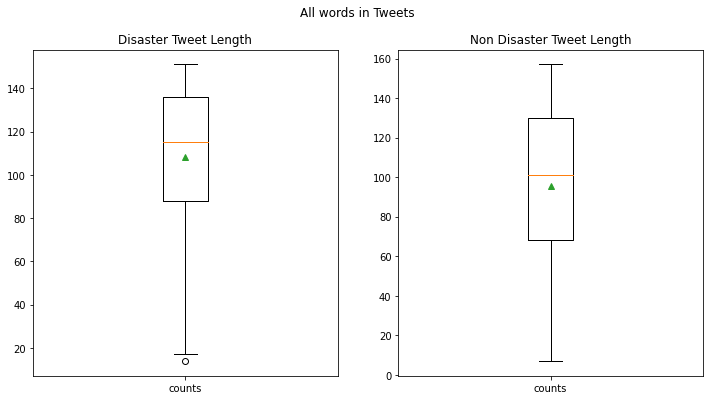

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].boxplot(disaster_tweet_len, labels=['counts'], showmeans=True)
ax[0].set_title("Disaster Tweet Length")

ax[1].boxplot(non_disaster_tweet_len, labels=['counts'], showmeans=True)
ax[1].set_title("Non Disaster Tweet Length")

fig.suptitle('All words in Tweets')
plt.show()

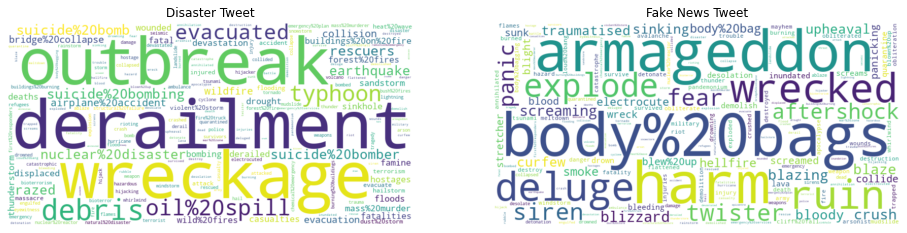

In [13]:
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target']==1]['keyword'].value_counts())
non_disaster_tweet_keywords = dict(train[train['target']==0]['keyword'].value_counts())

stopwords = set(STOPWORDS)
disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").\
generate_from_frequencies(disaster_tweet_keywords)
non_disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").\
generate_from_frequencies(non_disaster_tweet_keywords)


fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title("Disaster Tweet")
ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title("Fake News Tweet")
fig.show()

## 데이터 전처리
- 불필요한 컬럼 제거

In [16]:
# test_id 저장 / 결과 제출 시 재활용
test_id = test['id']

for datas in [train, test]:
    datas = datas.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
    
train.shape, test.shape

((7613, 2), (3263, 1))

- 데이터 확인

In [20]:
test.tail()

,text
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,#CityofCalgary has activated its Municipal Eme...


## 사용자 정의 함수
- url 제거 함수, 이모티콘 제거, 특수 문자 제거, 불용어 제거 등 

In [22]:
# URL 제거 함수
import re 

def remove_url(text):
    # url = re.compile(r'https?://\S+|www\.\S+')
    reg_text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return reg_text 
sample_text = '주소 : https://www.kaggle.com/code/j2hoon85/notebookdf77b60776/edit'
remove_url(sample_text)

'주소 : '

- HTML 태그 제거하는 함수

In [26]:
def remove_html(text):
    
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

sample_text ="""<div>
<h1> Real News or Fake News </h1>
<p> Kaggle Machine Learning </p>
</div>"""
    
remove_html(sample_text)

'\n Real News or Fake News \n Kaggle Machine Learning \n'

In [28]:
!pip install emoji --upgrade


In [29]:
import emoji
print(emoji.emojize('Phd is very easy!!! :thumbs_up:'))

Phd is very easy!!! 👍


In [30]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

remove_emoji("Hello, 👍")

'Hello, '

- 특수문자 제거 함수

In [36]:
def remove_punct(text):
    return re.sub("[^0-9가-힣a-zA-Z]", " ", text)

sample_text = "Hello, #1234 $안녕 #Outbreak, #Earthquake, May I have one question?"
remove_punct(sample_text)

'Hello       1234  안녕  Outbreak   Earthquake  May I have one question '

## 스탑워즈(stopwords)

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
from nltk.corpus import stopwords
print(len(stopwords.words('english')))

179


In [43]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [71]:
def data_cleansing(text, remove_stopwords = False):
    
    # remove url 
    url = re.compile(r'https?://\S+|www\.\S+')
    reg_text = url.sub(r'', text)
    
    # remove html
    html = re.compile(r'<.*?>')
    reg_text = html.sub(r'', reg_text)
    
    # remove emoji
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    reg_text = emoji_pattern.sub(r'', reg_text)
    
    # 특수문자 제거(Speicial Letters)
    reg_text = re.sub("[^a-zA-Z]", " ", reg_text)
    
    # Lowercase 
    reg_text = reg_text.lower().split() 
    
    # 불용어
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        
        # 사용자 정의 불용어 사전을 구축
        # stops = stops + [# 불용어 추가]
        
        reg_text = [word for word in reg_text if not word in stops]
        reg_text = ' '.join(reg_text)
    else:
        reg_text = ' '.join(reg_text)
        
    return reg_text 
    

In [72]:
clean_train_reviews = []
for datas in [train, test]:
    datas['cleaned_text'] = datas['text'].apply(lambda x : data_cleansing(x, remove_stopwords=True))

In [68]:
train.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [73]:
test.head(5)

,text,cleaned_text
0,Just happened a terrible car crash,happened terrible car crash
1,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


Tfidf Vectorizer

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df = 0.01, max_df=0.5, sublinear_tf=True)
X= tv.fit_transform(train['cleaned_text']).toarray()
y= train['target'].values

X.shape, y.shape

((7613, 69), (7613,))

In [81]:
#데이터셋 분리
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    X, y, test_size=0.3, random_state=42
)
train_input.shape, train_target.shape, val_input.shape, val_target.shape

((5329, 69), (5329,), (2284, 69), (2284,))

In [83]:
#모델링
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(train_input, train_target)


LogisticRegression(class_weight='balanced')

In [85]:
import numpy as np

test_tv = tv.transform(test['cleaned_text']).toarray()
print(test_tv.shape)

(3263, 69)


## 예측을 구하자

In [100]:
test_preds = lgs.predict(test_tv)
print(test_preds)
submission = pd.DataFrame({'id': test_id, 'target': test_preds})
submission.tail()

[1 0 1 ... 0 0 1]


,id,target
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,0
3262,10875,1


In [95]:
submission.to_csv("submission.csv", index=False)

In [101]:
submission_test = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_test.tail()

,id,target
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
3262,10875,0
